#  <font color='#57998f'>Computing Equilibria | FP & RL</font>
###  <font color='#37665f'>Dependencies</font> 

In [62]:
import time
import pulp
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

###  <font color='#37665f'>Games</font> 

In [500]:
# Game: matching pennies
payoff_matrix = np.array([[ 1,-1],
                          [-1, 1]])

# Game: rock-paper-scissors
payoff_matrix = np.array([[ 0,-1, 1],
                          [ 1, 0,-1],
                          [-1, 1, 0]])

# Game: zero-sum with pure nash equilibrium
payoff_matrix = np.array([[ 2, 0, 1],
                          [-4,-3, 2],
                          [ 1,-2,-2]])

##  <font color='#37665f'>Fictitious Play</font> 
### <font color='#425451'>Define FP Player</font> 

In [246]:
class FPZeroSumPlayer():

    def __init__(self, payoff_matrix, w_init=None):
        
        self.payoff_matrix = payoff_matrix
        
        if w_init == None:
            self.w = np.random.uniform(low=1, high=1.01, size=(len(self.payoff_matrix),))
        else:
            self.w = w_init
            
        self.p = self.w / np.sum(self.w)
        
        self.policy = np.zeros(len(self.payoff_matrix))
        
        self.update_policy()
                
        self.belief = None
        self.action = None
        self.reward = None


    def take_action(self, learning=True):
        
        self.belief = np.argmax(self.p)
        
        self.action = np.argmax(self.payoff_matrix[:,self.belief])

        return self.action

    
    def learn(self,opponent_action):
        
        self.w[opponent_action] += 1
        
        self.p = self.w / np.sum(self.w)
        
        self.reward = self.payoff_matrix[self.action][opponent_action]
                
        self.update_policy()
        
        
    def update_policy(self):
        
        new_policy = np.zeros(len(self.payoff_matrix))
            
        for idx, p in enumerate(self.p):
            new_policy[np.argmax(self.payoff_matrix[:,idx])] += p
            
        self.policy = new_policy

### <font color='#425451'>Define FP Play Game Function</font> 

In [320]:
def play_fp_game(player_1, player_2, actions_map, max_iterations, policy_delta_thres, stable_policy_delta_rounds_thres): 
    
    game_history = pd.DataFrame(columns=['round', 'action_1', 'action_2', 'beliefs_1', 'beliefs_2', 
                                         'policy_1', 'policy_2', 'reward_1', 'reward_2'])

    game_history = game_history.append({'beliefs_1':player_1.p.round(3), 'beliefs_2':player_2.p.round(3), 
                                        'policy_1':player_1.policy.round(3), 'policy_2':player_2.policy.round(3)},
                                       ignore_index=True)

    start_time = time.time()

    for i in range(1, max_iterations+1):

        action_1 = player_1.take_action()
        action_2 = player_2.take_action()

        player_1.learn(opponent_action=action_2)
        player_2.learn(opponent_action=action_1)  

        game_history = game_history.append({'round':i, 'action_1':actions_map[action_1], 'action_2':actions_map[action_2], 
                                            'beliefs_1':player_1.p.round(3), 'beliefs_2':player_2.p.round(3), 
                                            'policy_1':player_1.policy.round(3), 'policy_2':player_2.policy.round(3),
                                            'reward_1':player_1.reward, 'reward_2':player_2.reward}, ignore_index=True)

        policy_range_1 = (game_history.iloc[-stable_policy_delta_rounds_thres:,game_history.columns.get_loc('policy_1')].apply(pd.Series).min() \
                 - game_history.iloc[-stable_policy_delta_rounds_thres:,game_history.columns.get_loc('policy_1')].apply(pd.Series).max()) \
                 .abs().max()
        
        policy_range_2 = (game_history.iloc[-stable_policy_delta_rounds_thres:,game_history.columns.get_loc('policy_2')].apply(pd.Series).min() \
                 - game_history.iloc[-stable_policy_delta_rounds_thres:,game_history.columns.get_loc('policy_2')].apply(pd.Series).max()) \
                 .abs().max()

        if (policy_range_1 <= policy_delta_thres) & (policy_range_2 <= policy_delta_thres):

            print('Congrats! A Nash Equilibrium was reached! \U0001F389 \n')
            print('Player 1 policy: ' + str(player_1.policy.round(1)))
            print('Player 2 policy: ' + str(player_2.policy.round(1)))

            time_elapsed = time.time() - start_time 
            print('\nTime elapsed: {:.2f}s'.format(time_elapsed))
            print('Number of rounds elapsed: ' + str(i))

            break

    if (policy_range_1 > policy_delta_thres) | (policy_range_2 > policy_delta_thres):
        print('No Nash Equilibrium was reached based on the below defined criteria. \U0001F622')
        print('Policy delta threshold: ' + str(policy_delta_thres))
        print('Number of rounds with stable policy needed: ' + str(stable_policy_delta_rounds_thres))
        print('Max rounds: ' + str(max_iterations))
    
    plt.style.use('seaborn')
    color_plt = sns.color_palette('Set1')
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 4)

    for action in actions_map.keys():
        ax1.plot(game_history['round'], game_history['policy_1'].apply(pd.Series)[action], ls ='--', color=color_plt[action], label=actions_map[action])
        ax2.plot(game_history['round'], game_history['policy_2'].apply(pd.Series)[action], ls ='--', color=color_plt[action], label=actions_map[action])

    ax1.set_xlim(-10,game_history['round'].max()+10)
    ax2.set_xlim(-10,game_history['round'].max()+10)

    ax1.set_title('Player 1: Policy - Actions\' Probabilities \n\n No Nash Equilibrium', fontsize=13)
    ax2.set_title('Player 2: Policy - Actions\' Probabilities \n\n No Nash Equilibrium', fontsize=13)


    ax1.set_ylabel('Action Probability\n', fontsize=10, color='black')
    ax1.set_xlabel('Game Round', fontsize=10, color='black')
    ax2.set_xlabel('Game Round', fontsize=10, color='black')

    if (policy_range_1 <= policy_delta_thres) & (policy_range_2 <= policy_delta_thres):
        ax1.set_title('Player 1: Policy - Actions\' Probabilities \n\nNash Equilibrium: ' \
                      + str(game_history.iloc[-1,game_history.columns.get_loc('policy_1')].round(1)), fontsize=13)
        ax2.set_title('Player 2: Policy - Actions\' Probabilities \n\nNash Equilibrium: ' \
                      + str(game_history.iloc[-1,game_history.columns.get_loc('policy_2')].round(1)), fontsize=13)
        ax1.axvspan(game_history['round'].max() - stable_policy_delta_rounds_thres, game_history['round'].max()+10, facecolor='#7ff09d', alpha=0.1)
        ax2.axvspan(game_history['round'].max() - stable_policy_delta_rounds_thres, game_history['round'].max()+10, facecolor='#7ff09d', alpha=0.1)

    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')

    plt.show()
        
    return game_history

### <font color='#425451'>Experiments</font> 

####  <font color='#425451'>Game: Matching Pennies</font> 

<font color='#425451'>Configure Equilibrium Criteria</font> 

In [295]:
max_iterations = 3000

policy_delta_thres = 0.01

stable_policy_delta_rounds_thres = 50

<font color='#425451'>Game's Pay-off Matrix & action mapping</font> 

In [296]:
payoff_matrix = np.array([[ 1,-1],
                          [-1, 1]])

actions_map = {0: 'H', 1: 'T'}

<font color='#425451'>Initialize FP Players</font> 

In [297]:
player_1 = FPZeroSumPlayer(payoff_matrix)

column_payoff_matrix = (-1) * payoff_matrix.T

player_2 = FPZeroSumPlayer(column_payoff_matrix)

<font color='#425451'>Play Game</font> 

Congrats! A Nash Equilibrium was reached! 🎉 

Player 1 policy: [0.5 0.5]
Player 2 policy: [0.5 0.5]

Time elapsed: 231.41s
Number of rounds elapsed: 2506


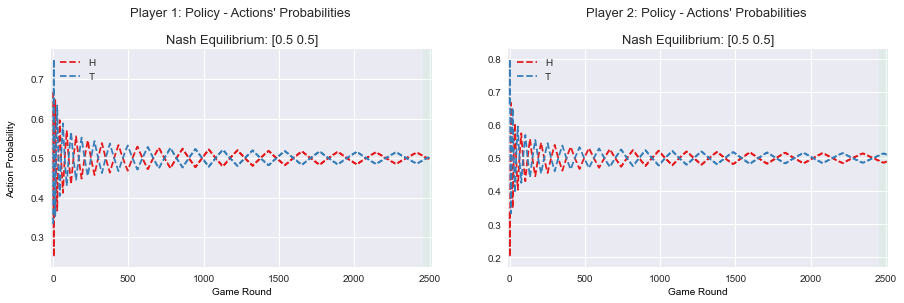

In [298]:
game_log = play_fp_game(player_1, player_2, actions_map, max_iterations, policy_delta_thres, stable_policy_delta_rounds_thres)

In [300]:
game_log.head(5)

,round,action_1,action_2,beliefs_1,beliefs_2,policy_1,policy_2,reward_1,reward_2
0,NaN,NaN,NaN,"[0.501, 0.499]","[0.499, 0.501]","[0.501, 0.499]","[0.501, 0.499]",NaN,NaN
1,1,H,H,"[0.667, 0.333]","[0.665, 0.335]","[0.667, 0.333]","[0.335, 0.665]",1,-1
2,2,H,T,"[0.5, 0.5]","[0.749, 0.251]","[0.5, 0.5]","[0.251, 0.749]",-1,1
3,3,H,T,"[0.4, 0.6]","[0.799, 0.201]","[0.4, 0.6]","[0.201, 0.799]",-1,1
4,4,T,T,"[0.334, 0.666]","[0.666, 0.334]","[0.334, 0.666]","[0.334, 0.666]",1,-1


<font color='#425451'>Try with other Nash Equilibrium criteria</font> 

No Nash Equilibrium was reached based on the below defined criteria. 😢
Policy delta threshold: 0.0001
Number of rounds with stable policy needed: 50
Max rounds: 1000


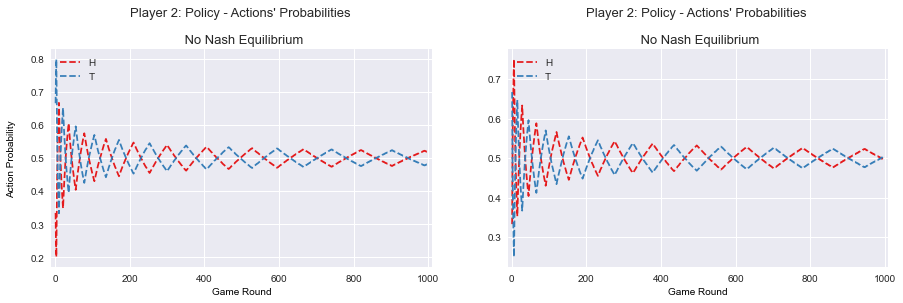

In [294]:
player_1 = FPZeroSumPlayer(payoff_matrix)
player_2 = FPZeroSumPlayer(column_payoff_matrix)

game_log = play_fp_game(player_1, player_2, actions_map, 
                        max_iterations=1000, policy_delta_thres=0.0001, stable_policy_delta_rounds_thres=50)

####  <font color='#425451'>Game: Rock-Paper-Scissors </font> 

<font color='#425451'>Configure Equilibrium Criteria</font> 

In [304]:
max_iterations = 2000
policy_delta_thres = 0.01
stable_policy_delta_rounds_thres = 30

<font color='#425451'>Game's Pay-off Matrix & action mapping</font> 

In [305]:
payoff_matrix = np.array([[ 0,-1, 1],
                          [ 1, 0,-1],
                          [-1, 1, 0]])

actions_map = {0: 'Rock', 1: 'Paper', 2:'Scissors'}

<font color='#425451'>Initialize FP Players</font> 

In [306]:
player_1 = FPZeroSumPlayer(payoff_matrix, w_init=[1,1,1])

column_payoff_matrix = (-1) * payoff_matrix.T

player_2 = FPZeroSumPlayer(column_payoff_matrix, w_init=[1,1,1])

<font color='#425451'>Play Game</font> 

Congrats! A Nash Equilibrium was reached! 🎉 

Player 1 policy: [0.3 0.3 0.3]
Player 2 policy: [0.3 0.3 0.3]

Time elapsed: 9.46s
Number of rounds elapsed: 171


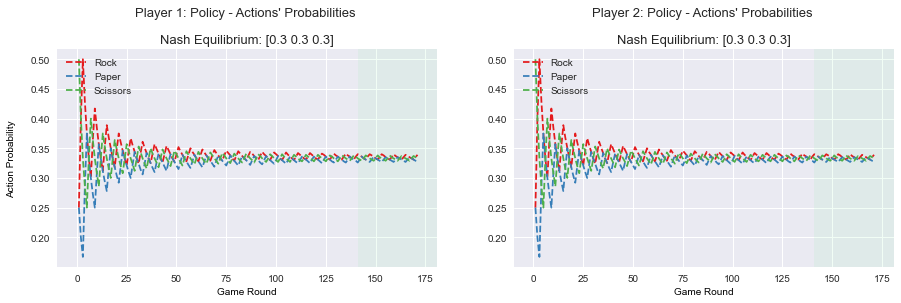

In [307]:
game_log = play_fp_game(player_1, player_2, actions_map, max_iterations, policy_delta_thres, stable_policy_delta_rounds_thres)

In [308]:
game_log[['round','action_1','action_2','beliefs_1','beliefs_2','policy_1','policy_2']].head(8)

,round,action_1,action_2,beliefs_1,beliefs_2,policy_1,policy_2
0,NaN,NaN,NaN,"[0.333, 0.333, 0.333]","[0.333, 0.333, 0.333]","[0.333, 0.333, 0.333]","[0.333, 0.333, 0.333]"
1,1,Paper,Paper,"[0.25, 0.5, 0.25]","[0.25, 0.5, 0.25]","[0.25, 0.25, 0.5]","[0.25, 0.25, 0.5]"
2,2,Scissors,Scissors,"[0.2, 0.4, 0.4]","[0.2, 0.4, 0.4]","[0.4, 0.2, 0.4]","[0.4, 0.2, 0.4]"
3,3,Scissors,Scissors,"[0.167, 0.333, 0.5]","[0.167, 0.333, 0.5]","[0.5, 0.167, 0.333]","[0.5, 0.167, 0.333]"
4,4,Rock,Rock,"[0.286, 0.286, 0.429]","[0.286, 0.286, 0.429]","[0.429, 0.286, 0.286]","[0.429, 0.286, 0.286]"
5,5,Rock,Rock,"[0.375, 0.25, 0.375]","[0.375, 0.25, 0.375]","[0.375, 0.375, 0.25]","[0.375, 0.375, 0.25]"
6,6,Paper,Paper,"[0.333, 0.333, 0.333]","[0.333, 0.333, 0.333]","[0.333, 0.333, 0.333]","[0.333, 0.333, 0.333]"
7,7,Paper,Paper,"[0.3, 0.4, 0.3]","[0.3, 0.4, 0.3]","[0.3, 0.3, 0.4]","[0.3, 0.3, 0.4]"


<font color='#425451'>Try with other initial beliefs</font> 

No Nash Equilibrium was reached based on the below defined criteria. 😢
Policy delta threshold: 0.01
Number of rounds with stable policy needed: 150
Max rounds: 5000


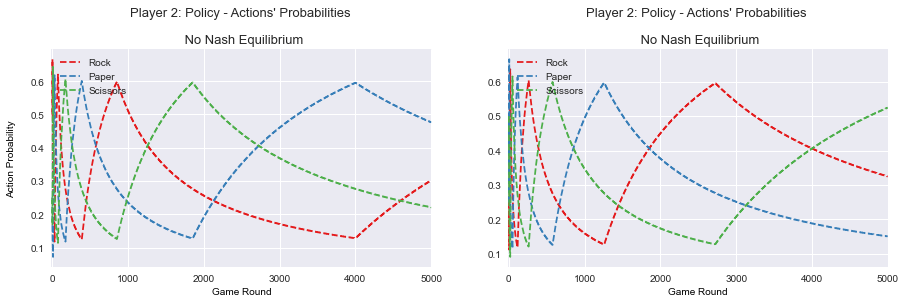

In [314]:
player_1 = FPZeroSumPlayer(payoff_matrix)
player_2 = FPZeroSumPlayer(column_payoff_matrix)

game_log = play_fp_game(player_1, player_2, actions_map, 
                        max_iterations=5000, policy_delta_thres=0.01, stable_policy_delta_rounds_thres=150)

Congrats! A Nash Equilibrium was reached! 🎉 

Player 1 policy: [0.3 0.3 0.3]
Player 2 policy: [0.3 0.3 0.3]

Time elapsed: 21.01s
Number of rounds elapsed: 189


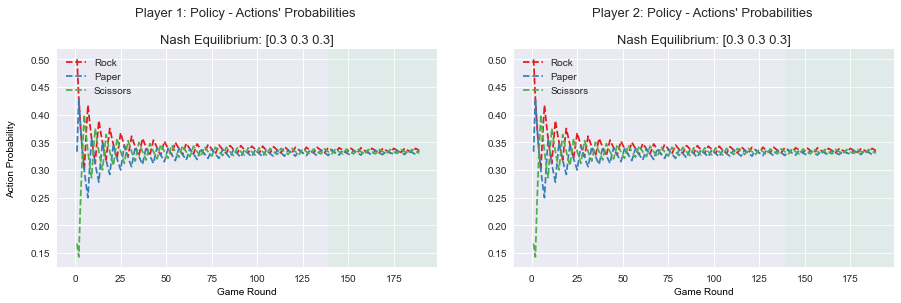

In [310]:
player_1 = FPZeroSumPlayer(payoff_matrix, w_init=[1,1,3])
player_2 = FPZeroSumPlayer(column_payoff_matrix, w_init=[1,1,3])

game_log = play_fp_game(player_1, player_2, actions_map, 
                        max_iterations, policy_delta_thres=0.01, stable_policy_delta_rounds_thres=50)

####  <font color='#425451'>Game: Pure Strategy Nash Equilibrium Game </font> 

<font color='#425451'>Configure Equilibrium Criteria</font> 

In [321]:
max_iterations = 2000
policy_delta_thres = 0.01
stable_policy_delta_rounds_thres = 30

<font color='#425451'>Game's Pay-off Matrix & action mapping</font> 

In [322]:
payoff_matrix = np.array([[ 2, 0, 1],
                          [-4,-3, 2],
                          [ 1,-2,-2]])

actions_map = {0: 'Action 1', 1: 'Action 2', 2:'Action 3'}

<font color='#425451'>Initialize FP Players</font> 

In [323]:
player_1 = FPZeroSumPlayer(payoff_matrix)

column_payoff_matrix = (-1) * payoff_matrix.T

player_2 = FPZeroSumPlayer(column_payoff_matrix)

<font color='#425451'>Play Game</font> 

Congrats! A Nash Equilibrium was reached! 🎉 

Player 1 policy: [1. 0. 0.]
Player 2 policy: [0. 1. 0.]

Time elapsed: 4.21s
Number of rounds elapsed: 69


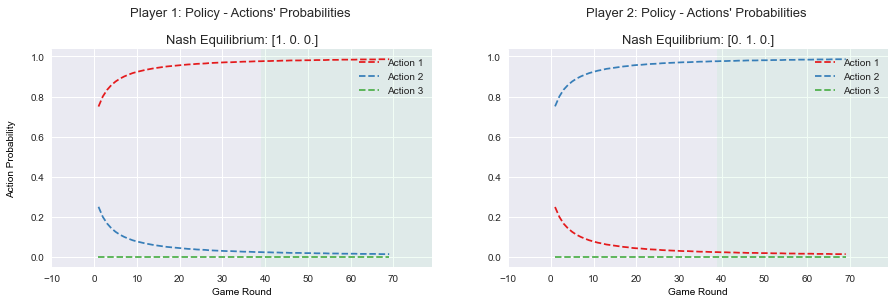

In [324]:
game_log = play_fp_game(player_1, player_2, actions_map, max_iterations, policy_delta_thres, stable_policy_delta_rounds_thres)

<font color='#425451'>Try with other Nash Equilibrium criteria</font> 

Congrats! A Nash Equilibrium was reached! 🎉 

Player 1 policy: [1. 0. 0.]
Player 2 policy: [0. 1. 0.]

Time elapsed: 13.75s
Number of rounds elapsed: 210


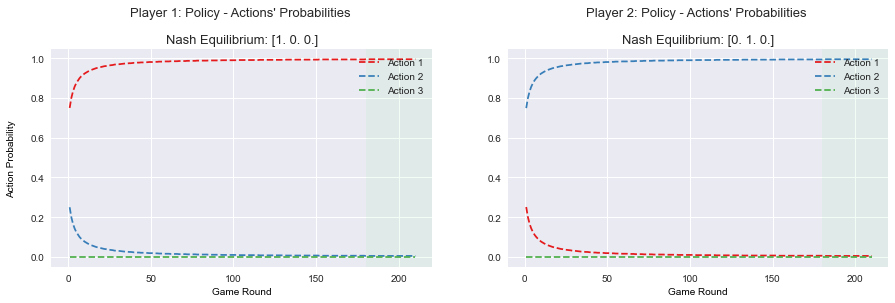

In [325]:
player_1 = FPZeroSumPlayer(payoff_matrix)
player_2 = FPZeroSumPlayer(column_payoff_matrix)

game_log = play_fp_game(player_1, player_2, actions_map, 
                        max_iterations, policy_delta_thres=0.000001, stable_policy_delta_rounds_thres=30)

## <font color='#37665f'>Reinforcement Learning</font> 
####  <font color='#425451'>Reward helper function</font> 

In [329]:
def get_reward(payoff_matrix, action_1, action_2):
    
    reward_1 = payoff_matrix[action_1, action_2]
    reward_2 = (-1) * payoff_matrix[action_1, action_2]

    return reward_1, reward_2

###  <font color='#425451'>Define Player</font> 

In [330]:
class RLZeroSumPlayer():

    def __init__(self, alpha, gamma, explor, actions, state_init='s'):

        self.alpha = alpha
        self.gamma = gamma
        self.explor = explor
        self.actions = actions
        self.state = state_init
        
        self.states = []
        
        self.Q = {}
        self.V = {}
        self.Pi = {}
        self.action = None

        self.init_state(state_init)

        self.game_history = []
        
    def init_state(self, state):
        
        self.states.append(state)
        
        self.V[state] = 1

        for action_1 in self.actions: 
            for action_2 in self.actions:
                self.Q[(state, action_1, action_2)] = 1

        for action in self.actions:
            self.Pi[(state, action)] = 1/len(self.actions) 


    def take_action(self, learning=True):

        if learning & (np.random.rand() < self.explor): 
            self.action = np.random.choice(self.actions)
        else:
            self.action = np.random.choice([i[1] for i in self.Pi.keys() if i[0]==self.state], 
                                           p=[self.Pi[i] for i in self.Pi.keys() if i[0]==self.state])   

        return self.action

    
    def learn(self, reward, opponent_action, state='s'):
        
        if state not in self.states: 
            self.init_state(state)
        
        self.update_Q(reward, opponent_action, state)
        self.update_Pi()
        self.update_V(state)
        
        self.game_history.append((self.state, self.action, opponent_action))
        
        self.state = state

    def update_Q(self, reward, opponent_action, new_state):
        
        kappa = len([i for i in player_1.game_history if i == (self.state, self.action, opponent_action)])
        alpha = 1/kappa if kappa>0 else self.alpha
        
        current_Q = self.Q[(self.state, self.action, opponent_action)]
        updated_Q = (1 - alpha)*current_Q + alpha*(reward + self.gamma*self.V[new_state])
        
        self.Q[(self.state, self.action, opponent_action)] = updated_Q

        
    def update_Pi(self):     
        
        pi = pulp.LpVariable.dicts('pi', self.actions, 0, 1)
        maxmin = pulp.LpVariable('maxmin')
        lp_prob = pulp.LpProblem('MaxMinQ', pulp.LpMaximize)
        lp_prob += (maxmin, 'Objective')
        lp_prob += (sum([pi[i] for i in self.actions]) == 1)

        for opponent_action in self.actions:
            label = '{}'.format(opponent_action)
            l = [pi[idx] * self.Q[(self.state, action, opponent_action)] for idx, action in enumerate(self.actions)]
            values = pulp.lpSum(l)
            condition = maxmin <= values
            lp_prob += condition

        lp_prob.solve(pulp.PULP_CBC_CMD(msg=0))

        for i in self.actions:
            self.Pi[(self.state,i)] = pi[i].value()
        
    def update_V(self, state):
        
        expected_values = []

        for opponent_action in self.actions:
            expected_value = sum([self.Pi[(state, action)]*self.Q[(state, action, opponent_action)] for action in self.actions])
            expected_values.append(expected_value)

        self.V[self.state] = min(expected_values)


### <font color='#425451'>Define RL Play Game Function</font> 

In [473]:
def play_rl_game(player_1, player_2, payoff_matrix, actions_map, max_iterations, policy_delta_thres, stable_policy_delta_rounds_thres): 
    
    actions = actions_map.keys()
    
    game_history = pd.DataFrame(columns=['round', 'action_1', 'action_2', 'reward_1', 'reward_2', 'V1', 'V2'] \
                                + ['Q1(' + actions_map[i]+ ',' + actions_map[j] + ')' for i in actions for j in actions] \
                                + ['Q2(' + actions_map[i]+ ',' + actions_map[j] + ')' for i in actions for j in actions] \
                                + ['Pi1(' + actions_map[i]+ ')' for i in actions] \
                                + ['Pi2(' + actions_map[i]+ ')' for i in actions])

    game_history = game_history.append({'V1':player_1.V['s'], 'V2':player_1.V['s']} \
                                        | {'Q1('+actions_map[i[1]]+','+actions_map[i[2]] + ')':player_1.Q[i] for i in player_1.Q} \
                                        | {'Q2('+actions_map[i[1]]+','+actions_map[i[2]] + ')':player_2.Q[i] for i in player_2.Q} \
                                        | {'Pi1('+actions_map[i[1]]+')':player_1.Pi[i] for i in player_1.Pi} \
                                        | {'Pi2('+actions_map[i[1]]+')':player_2.Pi[i] for i in player_2.Pi},
                                       ignore_index=True)

    start_time = time.time()

    for i in range(1, max_iterations+1):

        action_1 = player_1.take_action()
        action_2 = player_2.take_action()

        reward_1, reward_2 = get_reward(payoff_matrix, action_1, action_2)

        player_1.learn(reward=reward_1, opponent_action=action_2, state='s')
        player_2.learn(reward=reward_2, opponent_action=action_1, state='s')

        game_history = game_history.append({'round':i, 'action_1':actions_map[action_1], 'action_2':actions_map[action_2], 
                                            'reward_1':reward_1, 'reward_2':reward_2, 'V1':player_1.V['s'], 'V2':player_2.V['s']} \
                                            | {'Q1('+actions_map[i[1]]+','+actions_map[i[2]] + ')':player_1.Q[i] for i in player_1.Q} \
                                            | {'Q2('+actions_map[i[1]]+','+actions_map[i[2]] + ')':player_2.Q[i] for i in player_2.Q} \
                                            | {'Pi1('+actions_map[i[1]]+')':player_1.Pi[i] for i in player_1.Pi} \
                                            | {'Pi2('+actions_map[i[1]]+')':player_2.Pi[i] for i in player_2.Pi},
                                           ignore_index=True)

        max_policy_range = (game_history[[c for c in game_history.columns if 'Pi' in c]].iloc[-stable_policy_delta_rounds_thres:].max() \
                            - game_history[[c for c in game_history.columns if 'Pi' in c]].iloc[-stable_policy_delta_rounds_thres:].min()) \
                           .abs().max()

        if max_policy_range <= policy_delta_thres:

            print('Congrats! A Nash Equilibrium was reached! \U0001F389 \n')
            print('Player 1 policy: ' + str({'Pi1('+actions_map[i[1]]+')' : round(player_1.Pi[i],1) for i in player_1.Pi}))
            print('Player 2 policy: ' + str({'Pi1('+actions_map[i[1]]+')' : round(player_2.Pi[i],1) for i in player_2.Pi}))

            time_elapsed = time.time() - start_time 
            print('\nTime elapsed: {:.2f}s'.format(time_elapsed))
            print('Number of rounds elapsed: ' + str(i))

            break

    if max_policy_range > policy_delta_thres:
        print('No Nash Equilibrium was reached based on the below defined criteria. \U0001F622')
        print('Policy delta threshold: ' + str(policy_delta_thres))
        print('Number of rounds with stable policy needed: ' + str(stable_policy_delta_rounds_thres))
        print('Max rounds: ' + str(max_iterations))

    plt.style.use('seaborn')
    color_plt = sns.color_palette('Set1')
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 4)

    for action in actions_map.keys():
        ax1.plot(game_history['round'], game_history['Pi1({})'.format(actions_map[action])], ls ='--', color=color_plt[action], label=actions_map[action])
        ax2.plot(game_history['round'], game_history['Pi2({})'.format(actions_map[action])], ls ='--', color=color_plt[action], label=actions_map[action])

    ax1.set_xlim(-10,game_history['round'].max()+10)
    ax2.set_xlim(-10,game_history['round'].max()+10)

    ax1.set_title('Player 1: Policy - Actions\' Probabilities \n\n No Nash Equilibrium', fontsize=13)
    ax2.set_title('Player 2: Policy - Actions\' Probabilities \n\n No Nash Equilibrium', fontsize=13)


    ax1.set_ylabel('Action Probability\n', fontsize=10, color='black')
    ax1.set_xlabel('Game Round', fontsize=10, color='black')
    ax2.set_xlabel('Game Round', fontsize=10, color='black')

    if max_policy_range <= policy_delta_thres:
        ax1.set_title('Player 1: Policy - Actions\' Probabilities \n\nNash Equilibrium: ' \
                      +str({'Pi1('+actions_map[i[1]]+')' : round(player_1.Pi[i],1) for i in player_1.Pi}), fontsize=13)
        ax2.set_title('Player 2: Policy - Actions\' Probabilities \n\nNash Equilibrium: ' \
                      +str({'Pi1('+actions_map[i[1]]+')' : round(player_2.Pi[i],1) for i in player_2.Pi}), fontsize=13)
        ax1.axvspan(game_history['round'].max() - stable_policy_delta_rounds_thres, game_history['round'].max()+10, facecolor='#7ff09d', alpha=0.1)
        ax2.axvspan(game_history['round'].max() - stable_policy_delta_rounds_thres, game_history['round'].max()+10, facecolor='#7ff09d', alpha=0.1)

    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')

    plt.show()
    
    return game_history

### <font color='#425451'>Experiments</font> 

####  <font color='#425451'>Game: Matching Pennies</font> 

<font color='#425451'>Configure Equilibrium Criteria</font> 

In [579]:
max_iterations = 100

policy_delta_thres = 0.01

stable_policy_delta_rounds_thres = 50

<font color='#425451'>Game's Pay-off Matrix & action mapping</font> 

In [580]:
payoff_matrix = np.array([[ 1,-1],
                          [-1, 1]])

actions_map = {0: 'H', 1: 'T'}

<font color='#425451'>Initialize RL Players</font> 

In [581]:
alpha = 1
gamma = 0.9
explor = 0.2
initial_state = 's'
actions = list(range(len(payoff_matrix)))

player_1 = RLZeroSumPlayer(alpha, gamma, explor, actions, initial_state)
player_2 = RLZeroSumPlayer(alpha, gamma, explor, actions, initial_state)

<font color='#425451'>Play Game</font> 

Congrats! A Nash Equilibrium was reached! 🎉 

Player 1 policy: {'Pi1(H)': 0.5, 'Pi1(T)': 0.5}
Player 2 policy: {'Pi1(H)': 0.5, 'Pi1(T)': 0.5}

Time elapsed: 16.99s
Number of rounds elapsed: 82


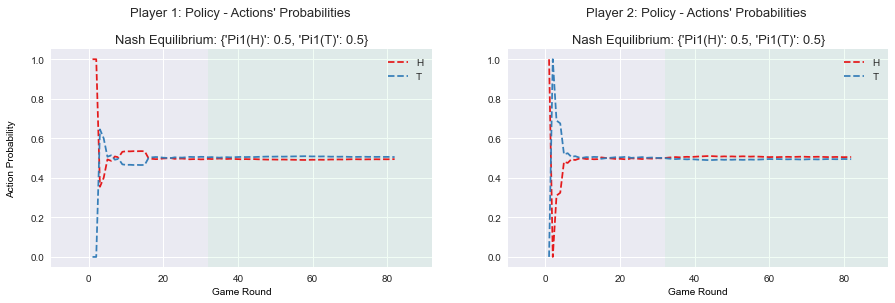

In [477]:
game_log = play_rl_game(player_1, player_2, payoff_matrix, actions_map, max_iterations, policy_delta_thres, stable_policy_delta_rounds_thres)

In [478]:
game_log

,round,action_1,action_2,reward_1,reward_2,V1,V2,"Q1(H,H)","Q1(H,T)","Q1(T,H)","Q1(T,T)","Q2(H,H)","Q2(H,T)","Q2(T,H)","Q2(T,T)",Pi1(H),Pi1(T),Pi2(H),Pi2(T)
0,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.500000,0.500000,0.500000
1,1.0,T,H,-1.0,1.0,1.000000,1.000000,1.000000,1.000000,-0.100000,1.000000,1.000000,1.900000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
2,2.0,H,H,1.0,-1.0,1.000000,1.000000,1.900000,1.000000,-0.100000,1.000000,-0.100000,1.900000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
3,3.0,H,T,-1.0,1.0,0.609677,1.279310,1.900000,-0.100000,-0.100000,1.000000,-0.100000,1.900000,1.900000,1.000000,0.354839,0.645161,0.310345,0.689655
4,4.0,H,H,1.0,-1.0,0.559793,1.291964,1.548710,-0.100000,-0.100000,1.000000,0.025690,1.900000,1.900000,1.000000,0.400188,0.599812,0.324405,0.675595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,78.0,T,T,1.0,-1.0,0.538877,0.762305,1.553838,-0.474833,-0.450935,1.527468,-0.208818,1.742675,1.756313,-0.241168,0.493727,0.506273,0.505823,0.494177
79,79.0,H,H,1.0,-1.0,0.538067,0.761093,1.550560,-0.474833,-0.450935,1.527468,-0.213595,1.742675,1.756313,-0.241168,0.494132,0.505868,0.505212,0.494788
80,80.0,H,T,-1.0,1.0,0.537506,0.760108,1.550560,-0.477106,-0.450935,1.527468,-0.213595,1.742675,1.752351,-0.241168,0.493851,0.506149,0.504715,0.495285
81,81.0,T,H,-1.0,1.0,0.536588,0.759333,1.550560,-0.477106,-0.454563,1.527468,-0.213595,1.739592,1.752351,-0.241168,0.494309,0.505691,0.505109,0.494891


<font color='#425451'>Try with other Nash Equilibrium criteria</font> 

Congrats! A Nash Equilibrium was reached! 🎉 

Player 1 policy: {'Pi1(H)': 0.5, 'Pi1(T)': 0.5}
Player 2 policy: {'Pi1(H)': 0.5, 'Pi1(T)': 0.5}

Time elapsed: 56.03s
Number of rounds elapsed: 253


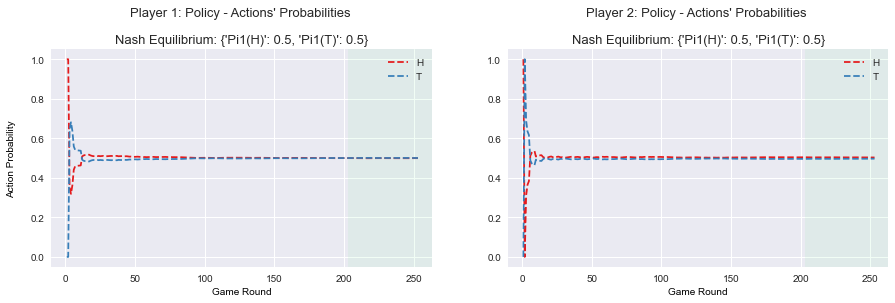

In [479]:
player_1 = RLZeroSumPlayer(alpha, gamma, explor, actions, initial_state)
player_2 = RLZeroSumPlayer(alpha, gamma, explor, actions, initial_state)

game_log = play_rl_game(player_1, player_2, payoff_matrix, actions_map, 
                        max_iterations=1000, policy_delta_thres=0.001, stable_policy_delta_rounds_thres=50)

<font color='#425451'>Try with other initial parameters</font> 

Congrats! A Nash Equilibrium was reached! 🎉 

Player 1 policy: {'Pi1(H)': 0.5, 'Pi1(T)': 0.5}
Player 2 policy: {'Pi1(H)': 0.5, 'Pi1(T)': 0.5}

Time elapsed: 36.45s
Number of rounds elapsed: 95


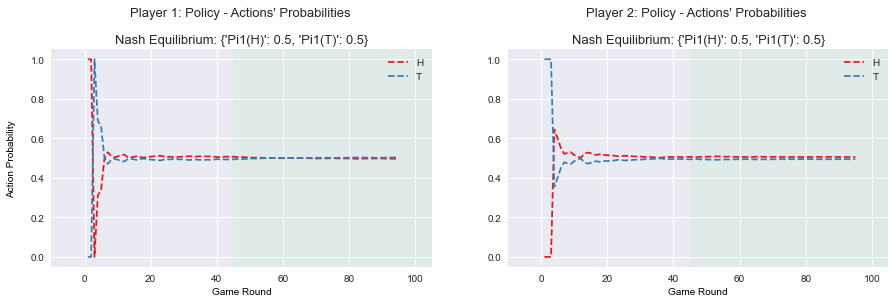

In [587]:
alpha = 1
gamma = 0.9
explor = 0.5
initial_state = 's'
actions = list(range(len(payoff_matrix)))

player_1 = RLZeroSumPlayer(alpha, gamma, explor, actions, initial_state)
player_2 = RLZeroSumPlayer(alpha, gamma, explor, actions, initial_state)

max_iterations=300
game_log = play_rl_game(player_1, player_2, payoff_matrix, actions_map, 
                        max_iterations, policy_delta_thres, stable_policy_delta_rounds_thres)

####  <font color='#425451'>Game: Rock-Paper-Scissors </font> 

<font color='#425451'>Configure Equilibrium Criteria</font> 

In [574]:
max_iterations = 2000
policy_delta_thres = 0.01
stable_policy_delta_rounds_thres = 30

<font color='#425451'>Game's Pay-off Matrix & action mapping</font> 

In [575]:
payoff_matrix = np.array([[ 0,-1, 1],
                          [ 1, 0,-1],
                          [-1, 1, 0]])

actions_map = {0: 'Rock', 1: 'Paper', 2:'Scissors'}

<font color='#425451'>Initialize FP Players</font> 

In [576]:
alpha = 1
gamma = 0.9
explor = 0.2
initial_state = 's'
actions = list(range(len(payoff_matrix)))

player_1 = RLZeroSumPlayer(alpha, gamma, explor, actions, initial_state)
player_2 = RLZeroSumPlayer(alpha, gamma, explor, actions, initial_state)

<font color='#425451'>Play Game</font> 

Congrats! A Nash Equilibrium was reached! 🎉 

Player 1 policy: {'Pi1(Rock)': 0.3, 'Pi1(Paper)': 0.3, 'Pi1(Scissors)': 0.3}
Player 2 policy: {'Pi1(Rock)': 0.3, 'Pi1(Paper)': 0.3, 'Pi1(Scissors)': 0.3}

Time elapsed: 17.07s
Number of rounds elapsed: 86


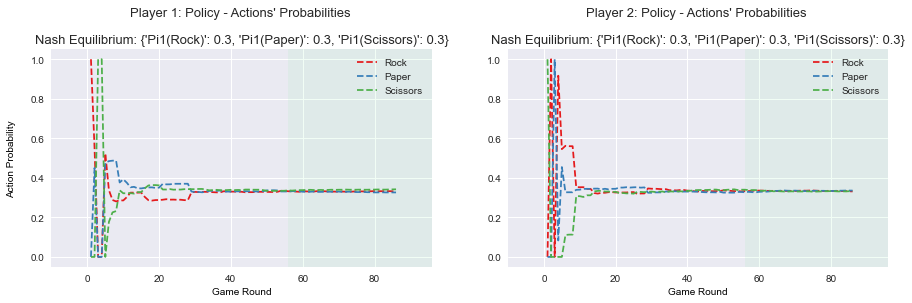

In [497]:
game_log = play_rl_game(player_1, player_2, payoff_matrix, actions_map, max_iterations, policy_delta_thres, stable_policy_delta_rounds_thres)

In [498]:
game_log

,round,action_1,action_2,reward_1,reward_2,V1,V2,"Q1(Rock,Rock)","Q1(Rock,Paper)","Q1(Rock,Scissors)",...,"Q2(Paper,Scissors)","Q2(Scissors,Rock)","Q2(Scissors,Paper)","Q2(Scissors,Scissors)",Pi1(Rock),Pi1(Paper),Pi1(Scissors),Pi2(Rock),Pi2(Paper),Pi2(Scissors)
0,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
1,1.0,Paper,Scissors,-1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.900000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2,2.0,Rock,Scissors,1.0,-1.0,1.000000,1.000000,1.000000,1.000000,1.900000,...,1.000000,-0.10000,1.900000,1.000000,0.550000,0.450000,0.000000,1.000000,0.000000,0.000000
3,3.0,Rock,Rock,0.0,0.0,1.000000,1.000000,0.900000,1.000000,1.900000,...,1.000000,-0.10000,1.900000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
4,4.0,Scissors,Paper,1.0,-1.0,1.000000,0.908333,0.900000,1.000000,1.900000,...,-0.100000,-0.10000,1.900000,1.000000,0.000000,0.000000,1.000000,0.916667,0.083333,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,82.0,Rock,Rock,0.0,0.0,0.611922,0.734247,0.590584,-0.388262,1.616839,...,-0.266718,-0.25667,1.726878,0.704625,0.332360,0.327103,0.340537,0.333605,0.335101,0.331294
83,83.0,Paper,Scissors,-1.0,1.0,0.611115,0.733571,0.590584,-0.388262,1.616839,...,-0.266718,-0.25667,1.720873,0.704625,0.333172,0.326300,0.340528,0.332954,0.335084,0.331962
84,84.0,Rock,Paper,-1.0,1.0,0.610554,0.733013,0.590584,-0.393407,1.616839,...,-0.266718,-0.25667,1.720873,0.704625,0.332608,0.326275,0.341117,0.332955,0.335659,0.331385
85,85.0,Paper,Paper,0.0,0.0,0.610116,0.732103,0.590584,-0.393407,1.616839,...,-0.266718,-0.25667,1.720873,0.704625,0.332168,0.326256,0.341576,0.332078,0.335635,0.332287


<font color='#425451'>Try with other initial parameters</font> 

Congrats! A Nash Equilibrium was reached! 🎉 

Player 1 policy: {'Pi1(Rock)': 0.3, 'Pi1(Paper)': 0.3, 'Pi1(Scissors)': 0.3}
Player 2 policy: {'Pi1(Rock)': 0.3, 'Pi1(Paper)': 0.3, 'Pi1(Scissors)': 0.4}

Time elapsed: 62.91s
Number of rounds elapsed: 168


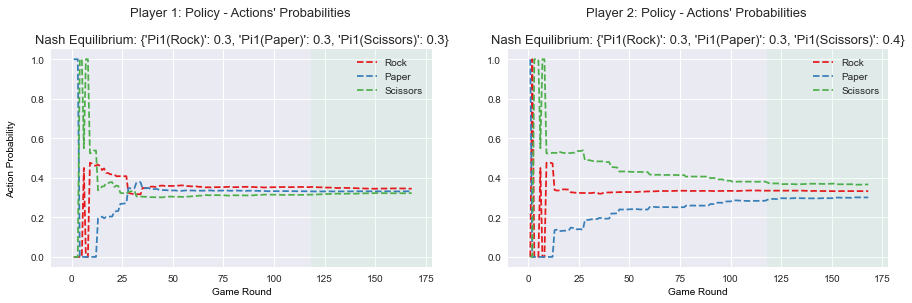

In [577]:
alpha = 1
gamma = 0.9
explor = 0.5
initial_state = 's'
actions = list(range(len(payoff_matrix)))

player_1 = RLZeroSumPlayer(alpha, gamma, explor, actions, initial_state)
player_2 = RLZeroSumPlayer(alpha, gamma, explor, actions, initial_state)

game_log = play_rl_game(player_1, player_2, payoff_matrix, actions_map, 
                        max_iterations, policy_delta_thres, stable_policy_delta_rounds_thres=50)

####  <font color='#425451'>Game: Pure Strategy Nash Equilibrium Game </font> 

<font color='#425451'>Configure Equilibrium Criteria</font> 

In [488]:
max_iterations = 2000
policy_delta_thres = 0.01
stable_policy_delta_rounds_thres = 30

<font color='#425451'>Game's Pay-off Matrix & action mapping</font> 

In [489]:
payoff_matrix = np.array([[ 2, 0, 1],
                          [-4,-3, 2],
                          [ 1,-2,-2]])

actions_map = {0: 'Action 1', 1: 'Action 2', 2:'Action 3'}

<font color='#425451'>Initialize FP Players</font> 

In [490]:
alpha = 1
gamma = 0.9
explor = 0.2
initial_state = 's'
actions = list(range(len(payoff_matrix)))

player_1 = RLZeroSumPlayer(alpha, gamma, explor, actions, initial_state)
player_2 = RLZeroSumPlayer(alpha, gamma, explor, actions, initial_state)

<font color='#425451'>Play Game</font> 

Congrats! A Nash Equilibrium was reached! 🎉 

Player 1 policy: {'Pi1(Action 1)': 1.0, 'Pi1(Action 2)': 0.0, 'Pi1(Action 3)': 0.0}
Player 2 policy: {'Pi1(Action 1)': 0.0, 'Pi1(Action 2)': 1.0, 'Pi1(Action 3)': 0.0}

Time elapsed: 9.66s
Number of rounds elapsed: 44


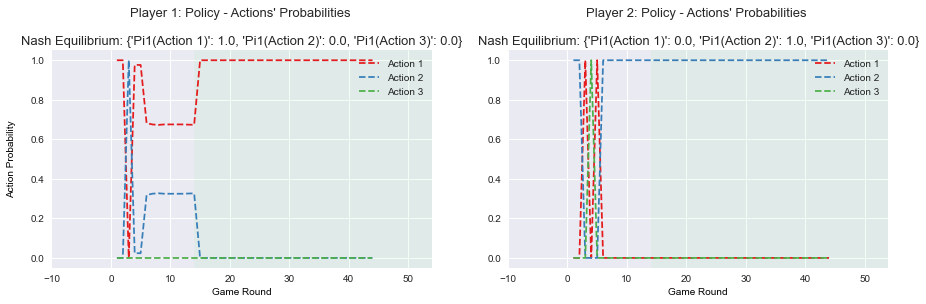

In [491]:
game_log = play_rl_game(player_1, player_2, payoff_matrix, actions_map, max_iterations, policy_delta_thres, stable_policy_delta_rounds_thres)

In [492]:
game_log

,round,action_1,action_2,reward_1,reward_2,V1,V2,"Q1(Action 1,Action 1)","Q1(Action 1,Action 2)","Q1(Action 1,Action 3)",...,"Q2(Action 2,Action 3)","Q2(Action 3,Action 1)","Q2(Action 3,Action 2)","Q2(Action 3,Action 3)",Pi1(Action 1),Pi1(Action 2),Pi1(Action 3),Pi2(Action 1),Pi2(Action 2),Pi2(Action 3)
0,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.0,1.00000,1.0,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
1,1.0,Action 3,Action 2,-2.0,2.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.900000,1.0,1.00000,1.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
2,2.0,Action 3,Action 2,-2.0,2.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.900000,1.0,1.00000,1.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
3,3.0,Action 1,Action 2,0.0,0.0,1.000000,1.000000,1.000000,0.900000,1.000000,...,2.900000,1.0,1.00000,1.0,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
4,4.0,Action 2,Action 1,-4.0,4.0,0.902381,1.000000,1.000000,0.900000,1.000000,...,2.900000,1.0,1.00000,1.0,0.976190,0.023810,0.000000,0.000000,0.000000,1.000000
5,5.0,Action 1,Action 3,1.0,-1.0,0.902381,1.000000,1.000000,0.900000,1.812143,...,2.900000,-0.1,1.00000,1.0,0.976190,0.023810,0.000000,1.000000,0.000000,0.000000
6,6.0,Action 1,Action 1,2.0,-2.0,0.931805,0.900000,2.812143,0.900000,1.812143,...,2.900000,-0.1,1.00000,1.0,0.681953,0.318047,0.000000,0.000000,1.000000,0.000000
7,7.0,Action 1,Action 2,0.0,0.0,0.891061,0.810000,2.812143,0.838624,1.812143,...,2.900000,-0.1,1.00000,1.0,0.675062,0.324938,0.000000,0.000000,1.000000,0.000000
8,8.0,Action 1,Action 2,0.0,0.0,0.879050,0.729000,2.812143,0.820290,1.812143,...,2.900000,-0.1,1.00000,1.0,0.673030,0.326970,0.000000,0.000000,1.000000,0.000000
9,9.0,Action 1,Action 1,2.0,-2.0,0.878631,0.729000,2.791145,0.820290,1.812143,...,2.900000,-0.1,1.00000,1.0,0.675358,0.324642,0.000000,0.000000,1.000000,0.000000


<font color='#425451'>Try with other Nash Equilibrium criteria</font> 

Congrats! A Nash Equilibrium was reached! 🎉 

Player 1 policy: {'Pi1(Action 1)': 1.0, 'Pi1(Action 2)': 0.0, 'Pi1(Action 3)': 0.0}
Player 2 policy: {'Pi1(Action 1)': 0.0, 'Pi1(Action 2)': 1.0, 'Pi1(Action 3)': 0.0}

Time elapsed: 8.14s
Number of rounds elapsed: 35


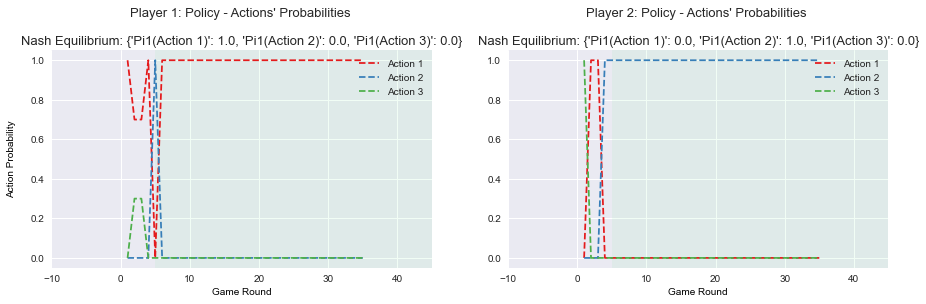

In [493]:
player_1 = RLZeroSumPlayer(alpha, gamma, explor, actions, initial_state)
player_2 = RLZeroSumPlayer(alpha, gamma, explor, actions, initial_state)

game_log = play_rl_game(player_1, player_2, payoff_matrix, actions_map, 
                        max_iterations, policy_delta_thres=0.000001, stable_policy_delta_rounds_thres=30)

## <font color='#37665f'>Reinforcement Learning VS Ficticious Play</font> 

### <font color='#425451'>Define FP vs RL Play Game Function</font> 

In [540]:
def play_fp_rl_game(player_FP, player_RL, payoff_matrix, actions_map, max_iterations, policy_delta_thres, stable_policy_delta_rounds_thres): 
    
    actions = actions_map.keys()

    game_history = pd.DataFrame(columns=['round', 'action_FP', 'action_RL', 'reward_FP', 'reward_RL', 'beliefs_FP', 'policy_FP', 'V_RL'] \
                                        + ['Q_RL(' + actions_map[i]+ ',' + actions_map[j] + ')' for i in actions for j in actions] \
                                        + ['Pi_RL(' + actions_map[i]+ ')' for i in actions])

    game_history = game_history.append({'beliefs_FP':player_FP.p.round(3), 'policy_FP':player_FP.p.round(3), 'V_RL':player_RL.V['s']} \
                                        | {'Q_RL('+actions_map[i[1]]+','+actions_map[i[2]] + ')':player_RL.Q[i] for i in player_RL.Q} \
                                        | {'Pi_RL('+actions_map[i[1]]+')':player_RL.Pi[i] for i in player_RL.Pi},
                                       ignore_index=True)

    start_time = time.time()

    for i in range(1, max_iterations+1):

        action_FP = player_FP.take_action()
        action_RL = player_RL.take_action()

        reward_FP, reward_RL = get_reward(payoff_matrix, action_FP, action_RL)

        player_FP.learn(opponent_action=action_RL)
        player_RL.learn(reward=reward_FP, opponent_action=action_FP, state='s')

        game_history = game_history.append({'round':i, 'action_FP':actions_map[action_FP], 'action_RL':actions_map[action_RL], 
                                            'reward_FP':reward_FP, 'reward_RL':reward_RL, 'beliefs_FP':player_FP.p.round(3), 
                                            'policy_FP':player_FP.p.round(3), 'V_RL':player_RL.V['s']} \
                                           | {'Q_RL('+actions_map[i[1]]+','+actions_map[i[2]] + ')':player_RL.Q[i] for i in player_RL.Q} \
                                           | {'Pi_RL('+actions_map[i[1]]+')':player_RL.Pi[i] for i in player_RL.Pi},
                                       ignore_index=True)

        policy_range_FP = (game_history.iloc[-stable_policy_delta_rounds_thres:,game_history.columns.get_loc('policy_FP')].apply(pd.Series).min() \
                           - game_history.iloc[-stable_policy_delta_rounds_thres:,game_history.columns.get_loc('policy_FP')].apply(pd.Series).max()) \
                           .abs().max()

        policy_range_RL = (game_history[[c for c in game_history.columns if 'Pi' in c]].iloc[-stable_policy_delta_rounds_thres:].max() \
                            - game_history[[c for c in game_history.columns if 'Pi' in c]].iloc[-stable_policy_delta_rounds_thres:].min()) \
                            .abs().max()

        if (policy_range_FP <= policy_delta_thres) & (policy_range_RL <= policy_delta_thres):

            print('Congrats! A Nash Equilibrium was reached! \U0001F389 \n')
            print('Player FP policy: ' + str(player_FP.policy.round(1)))
            print('Player RL policy: ' + str({'Pi_RL('+actions_map[i[1]]+')' : round(player_RL.Pi[i],1) for i in player_RL.Pi}))

            time_elapsed = time.time() - start_time 
            print('\nTime elapsed: {:.2f}s'.format(time_elapsed))
            print('Number of rounds elapsed: ' + str(i))

            break

    if (policy_range_FP > policy_delta_thres) | (policy_range_RL > policy_delta_thres):
        print('No Nash Equilibrium was reached based on the below defined criteria. \U0001F622')
        print('Policy delta threshold: ' + str(policy_delta_thres))
        print('Number of rounds with stable policy needed: ' + str(stable_policy_delta_rounds_thres))
        print('Max rounds: ' + str(max_iterations))

    plt.style.use('seaborn')
    color_plt = sns.color_palette('Set1')
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 4)

    for action in actions_map.keys():
        ax1.plot(game_history['round'], game_history['policy_FP'].apply(pd.Series)[action], ls ='--', color=color_plt[action], label=actions_map[action])
        ax2.plot(game_history['round'], game_history['Pi_RL({})'.format(actions_map[action])], ls ='--', color=color_plt[action], label=actions_map[action])

    ax1.set_xlim(-10,game_history['round'].max()+10)
    ax2.set_xlim(-10,game_history['round'].max()+10)

    ax1.set_title('Player FP: Policy - Actions\' Probabilities \n\n No Nash Equilibrium', fontsize=13)
    ax2.set_title('Player RL: Policy - Actions\' Probabilities \n\n No Nash Equilibrium', fontsize=13)


    ax1.set_ylabel('Action Probability\n', fontsize=10, color='black')
    ax1.set_xlabel('Game Round', fontsize=10, color='black')
    ax2.set_xlabel('Game Round', fontsize=10, color='black')

    if (policy_range_FP <= policy_delta_thres) & (policy_range_RL <= policy_delta_thres):
        ax1.set_title('Player FP: Policy - Actions\' Probabilities \n\nNash Equilibrium: ' \
                      + str(game_history.iloc[-1,game_history.columns.get_loc('policy_FP')].round(1)), fontsize=13)
        ax2.set_title('Player RL: Policy - Actions\' Probabilities \n\nNash Equilibrium: ' \
                      +str({'Pi_RL('+actions_map[i[1]]+')' : round(player_RL.Pi[i],1) for i in player_RL.Pi}), fontsize=13)
        ax1.axvspan(game_history['round'].max() - stable_policy_delta_rounds_thres, game_history['round'].max()+10, facecolor='#7ff09d', alpha=0.1)
        ax2.axvspan(game_history['round'].max() - stable_policy_delta_rounds_thres, game_history['round'].max()+10, facecolor='#7ff09d', alpha=0.1)

    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')

    plt.show()
    return game_history

### <font color='#425451'>Experiments</font> 

####  <font color='#425451'>Game: Matching Pennies</font> 

<font color='#425451'>Configure Equilibrium Criteria</font> 

In [533]:
max_iterations = 1000

policy_delta_thres = 0.01

stable_policy_delta_rounds_thres = 50

<font color='#425451'>Game's Pay-off Matrix & action mapping</font> 

In [534]:
payoff_matrix = np.array([[ 1,-1],
                          [-1, 1]])

actions_map = {0: 'H', 1: 'T'}

<font color='#425451'>Initialize RL Players</font> 

In [543]:
alpha = 1
gamma = 0.9
explor = 0.2
initial_state = 's'
actions = list(range(len(payoff_matrix)))

player_FP = FPZeroSumPlayer(payoff_matrix)
player_RL = RLZeroSumPlayer(alpha, gamma, explor, actions, initial_state)

<font color='#425451'>Play Game</font> 

Congrats! A Nash Equilibrium was reached! 🎉 

Player FP policy: [0.1 0.9]
Player RL policy: {'Pi_RL(H)': 0.0, 'Pi_RL(T)': 1.0}

Time elapsed: 64.23s
Number of rounds elapsed: 294


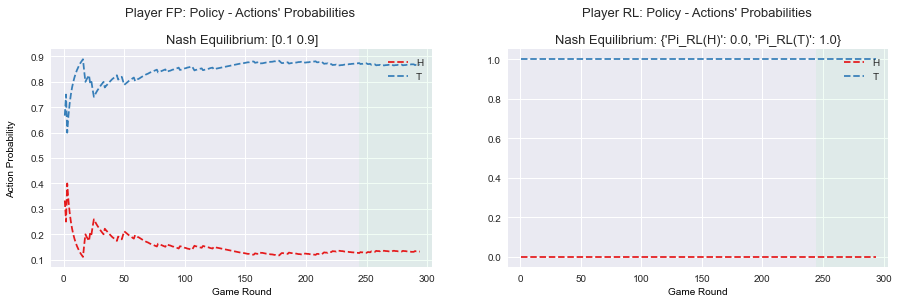

In [544]:
game_log = play_fp_rl_game(player_FP, player_RL, payoff_matrix, actions_map, max_iterations, policy_delta_thres, stable_policy_delta_rounds_thres)

In [546]:
game_log

,round,action_FP,action_RL,reward_FP,reward_RL,beliefs_FP,policy_FP,V_RL,"Q_RL(H,H)","Q_RL(H,T)","Q_RL(T,H)","Q_RL(T,T)",Pi_RL(H),Pi_RL(T)
0,NaN,NaN,NaN,NaN,NaN,"[0.499, 0.501]","[0.499, 0.501]",1,1,1,1,1,0.5,0.5
1,1.0,T,T,1.0,-1.0,"[0.333, 0.667]","[0.333, 0.667]",1.0,1,1,1,1.007087,0.0,1.0
2,2.0,T,T,1.0,-1.0,"[0.25, 0.75]","[0.25, 0.75]",1.0,1,1,1,1.014117,0.0,1.0
3,3.0,T,H,-1.0,1.0,"[0.4, 0.6]","[0.4, 0.6]",1.0,1,0.990179,1,1.014117,0.0,1.0
4,4.0,T,T,1.0,-1.0,"[0.333, 0.667]","[0.333, 0.667]",1.0,1,0.990179,1,1.021093,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,290.0,T,H,-1.0,1.0,"[0.134, 0.866]","[0.134, 0.866]",1.0,1,0.682314,1,1.777233,0.0,1.0
291,291.0,T,T,1.0,-1.0,"[0.133, 0.867]","[0.133, 0.867]",1.0,1,0.682314,1,1.7782,0.0,1.0
292,292.0,T,T,1.0,-1.0,"[0.133, 0.867]","[0.133, 0.867]",1.0,1,0.682314,1,1.779159,0.0,1.0
293,293.0,T,T,1.0,-1.0,"[0.132, 0.868]","[0.132, 0.868]",1.0,1,0.682314,1,1.78011,0.0,1.0


<font color='#425451'>Try again</font> 

Congrats! A Nash Equilibrium was reached! 🎉 

Player FP policy: [0.5 0.5]
Player RL policy: {'Pi_RL(H)': 0.5, 'Pi_RL(T)': 0.5}

Time elapsed: 74.05s
Number of rounds elapsed: 328


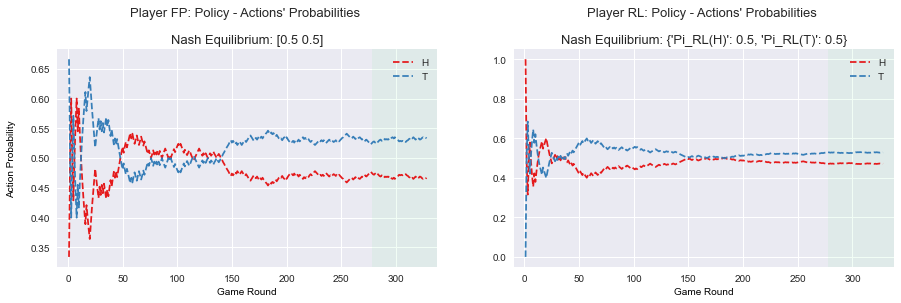

In [550]:
player_FP = FPZeroSumPlayer(payoff_matrix)
player_RL = RLZeroSumPlayer(alpha, gamma, explor, actions, initial_state)

game_log = play_fp_rl_game(player_FP, player_RL, payoff_matrix, actions_map, max_iterations, policy_delta_thres, stable_policy_delta_rounds_thres)

####  <font color='#425451'>Game: Rock-Paper-Scissors </font> 

<font color='#425451'>Configure Equilibrium Criteria</font> 

In [553]:
max_iterations = 2000
policy_delta_thres = 0.01
stable_policy_delta_rounds_thres = 30

<font color='#425451'>Game's Pay-off Matrix & action mapping</font> 

In [554]:
payoff_matrix = np.array([[ 0,-1, 1],
                          [ 1, 0,-1],
                          [-1, 1, 0]])

actions_map = {0: 'Rock', 1: 'Paper', 2:'Scissors'}

<font color='#425451'>Initialize FP Players</font> 

In [555]:
alpha = 1
gamma = 0.9
explor = 0.2
initial_state = 's'
actions = list(range(len(payoff_matrix)))

player_FP = FPZeroSumPlayer(payoff_matrix)
player_RL = RLZeroSumPlayer(alpha, gamma, explor, actions, initial_state)

<font color='#425451'>Play Game</font> 

Congrats! A Nash Equilibrium was reached! 🎉 

Player FP policy: [0.1 0.1 0.8]
Player RL policy: {'Pi_RL(Rock)': 0.0, 'Pi_RL(Paper)': 1.0, 'Pi_RL(Scissors)': 0.0}

Time elapsed: 57.33s
Number of rounds elapsed: 284


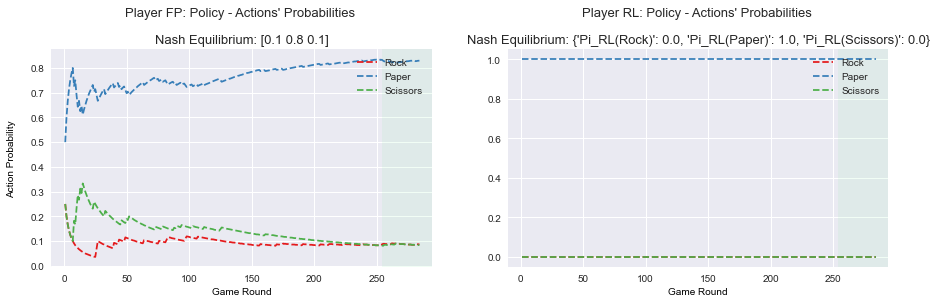

In [556]:
game_log = play_fp_rl_game(player_FP, player_RL, payoff_matrix, actions_map, max_iterations, policy_delta_thres, stable_policy_delta_rounds_thres)

In [557]:
game_log

,round,action_FP,action_RL,reward_FP,reward_RL,beliefs_FP,policy_FP,V_RL,"Q_RL(Rock,Rock)","Q_RL(Rock,Paper)","Q_RL(Rock,Scissors)","Q_RL(Paper,Rock)","Q_RL(Paper,Paper)","Q_RL(Paper,Scissors)","Q_RL(Scissors,Rock)","Q_RL(Scissors,Paper)","Q_RL(Scissors,Scissors)",Pi_RL(Rock),Pi_RL(Paper),Pi_RL(Scissors)
0,NaN,NaN,NaN,NaN,NaN,"[0.333, 0.334, 0.333]","[0.333, 0.334, 0.333]",1,1,1,1,1,1,1,1,1,1,0.333333,0.333333,0.333333
1,1.0,Scissors,Paper,1.0,-1.0,"[0.25, 0.5, 0.25]","[0.25, 0.5, 0.25]",1.0,1,1,1,1,1,1.007438,1,1,1,0.000000,1.000000,0.000000
2,2.0,Scissors,Paper,1.0,-1.0,"[0.2, 0.6, 0.2]","[0.2, 0.6, 0.2]",1.0,1,1,1,1,1,1.014815,1,1,1,0.000000,1.000000,0.000000
3,3.0,Scissors,Paper,1.0,-1.0,"[0.167, 0.666, 0.167]","[0.167, 0.666, 0.167]",1.0,1,1,1,1,1,1.02213,1,1,1,0.000000,1.000000,0.000000
4,4.0,Scissors,Paper,1.0,-1.0,"[0.143, 0.714, 0.143]","[0.143, 0.714, 0.143]",1.0,1,1,1,1,1,1.029385,1,1,1,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,280.0,Scissors,Paper,1.0,-1.0,"[0.085, 0.83, 0.085]","[0.085, 0.83, 0.085]",1.0,1,1,0.782685,1,1,1.770915,1,1,0.98151,0.000000,1.000000,0.000000
281,281.0,Scissors,Rock,-1.0,1.0,"[0.088, 0.827, 0.085]","[0.088, 0.827, 0.085]",1.0,1,1,0.774278,1,1,1.770915,1,1,0.98151,0.000000,1.000000,0.000000
282,282.0,Scissors,Paper,1.0,-1.0,"[0.088, 0.828, 0.084]","[0.088, 0.828, 0.084]",1.0,1,1,0.774278,1,1,1.771981,1,1,0.98151,0.000000,1.000000,0.000000
283,283.0,Scissors,Paper,1.0,-1.0,"[0.087, 0.829, 0.084]","[0.087, 0.829, 0.084]",1.0,1,1,0.774278,1,1,1.773039,1,1,0.98151,0.000000,1.000000,0.000000


####  <font color='#425451'>Game: Pure Strategy Nash Equilibrium Game </font> 

<font color='#425451'>Configure Equilibrium Criteria</font> 

In [563]:
max_iterations = 500
policy_delta_thres = 0.01
stable_policy_delta_rounds_thres = 30

<font color='#425451'>Game's Pay-off Matrix & action mapping</font> 

In [564]:
payoff_matrix = np.array([[ 2, 0, 1],
                          [-4,-3, 2],
                          [ 1,-2,-2]])

actions_map = {0: 'Action 1', 1: 'Action 2', 2:'Action 3'}

<font color='#425451'>Initialize FP Players</font> 

In [565]:
alpha = 1
gamma = 0.9
explor = 0.2
initial_state = 's'
actions = list(range(len(payoff_matrix)))

player_FP = FPZeroSumPlayer(payoff_matrix)
player_RL = RLZeroSumPlayer(alpha, gamma, explor, actions, initial_state)

<font color='#425451'>Play Game</font> 

Congrats! A Nash Equilibrium was reached! 🎉 

Player FP policy: [0.9 0.1 0. ]
Player RL policy: {'Pi_RL(Action 1)': 1.0, 'Pi_RL(Action 2)': 0.0, 'Pi_RL(Action 3)': 0.0}

Time elapsed: 47.99s
Number of rounds elapsed: 211


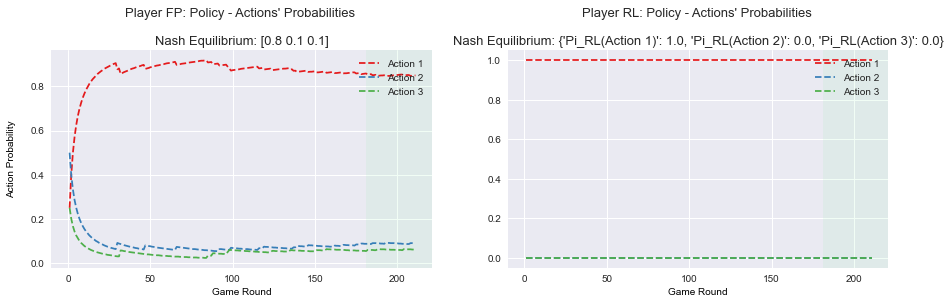

In [566]:
game_log = play_fp_rl_game(player_FP, player_RL, payoff_matrix, actions_map, max_iterations, policy_delta_thres, stable_policy_delta_rounds_thres)

In [567]:
game_log

,round,action_FP,action_RL,reward_FP,reward_RL,beliefs_FP,policy_FP,V_RL,"Q_RL(Action 1,Action 1)","Q_RL(Action 1,Action 2)","Q_RL(Action 1,Action 3)","Q_RL(Action 2,Action 1)","Q_RL(Action 2,Action 2)","Q_RL(Action 2,Action 3)","Q_RL(Action 3,Action 1)","Q_RL(Action 3,Action 2)","Q_RL(Action 3,Action 3)",Pi_RL(Action 1),Pi_RL(Action 2),Pi_RL(Action 3)
0,NaN,NaN,NaN,NaN,NaN,"[0.332, 0.334, 0.333]","[0.332, 0.334, 0.333]",1,1,1,1,1,1,1,1,1,1,0.333333,0.333333,0.333333
1,1.0,Action 1,Action 2,0.0,0.0,"[0.25, 0.5, 0.25]","[0.25, 0.5, 0.25]",1.0,1,1,1,0.999153,1,1,1,1,1,1.000000,0.000000,0.000000
2,2.0,Action 1,Action 1,2.0,-2.0,"[0.399, 0.4, 0.201]","[0.399, 0.4, 0.201]",1.0,1.022093,1,1,0.999153,1,1,1,1,1,1.000000,0.000000,0.000000
3,3.0,Action 1,Action 1,2.0,-2.0,"[0.499, 0.334, 0.167]","[0.499, 0.334, 0.167]",1.0,1.043929,1,1,0.999153,1,1,1,1,1,1.000000,0.000000,0.000000
4,4.0,Action 1,Action 1,2.0,-2.0,"[0.57, 0.286, 0.143]","[0.57, 0.286, 0.143]",1.0,1.065511,1,1,0.999153,1,1,1,1,1,1.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,207.0,Action 1,Action 1,2.0,-2.0,"[0.852, 0.086, 0.062]","[0.852, 0.086, 0.062]",1.0,2.663082,1,1,0.98653,1,1,1.097637,1,1,1.000000,0.000000,0.000000
208,208.0,Action 1,Action 2,0.0,0.0,"[0.848, 0.09, 0.062]","[0.848, 0.09, 0.062]",1.0,2.663082,1,1,0.985796,1,1,1.097637,1,1,1.000000,0.000000,0.000000
209,209.0,Action 1,Action 1,2.0,-2.0,"[0.849, 0.09, 0.061]","[0.849, 0.09, 0.061]",1.0,2.665837,1,1,0.985796,1,1,1.097637,1,1,1.000000,0.000000,0.000000
210,210.0,Action 1,Action 1,2.0,-2.0,"[0.85, 0.089, 0.061]","[0.85, 0.089, 0.061]",1.0,2.66856,1,1,0.985796,1,1,1.097637,1,1,1.000000,0.000000,0.000000


<font color='#425451'>Try Again</font> 

Congrats! A Nash Equilibrium was reached! 🎉 

Player FP policy: [0.9 0.1 0. ]
Player RL policy: {'Pi_RL(Action 1)': 1.0, 'Pi_RL(Action 2)': 0.0, 'Pi_RL(Action 3)': 0.0}

Time elapsed: 54.10s
Number of rounds elapsed: 297


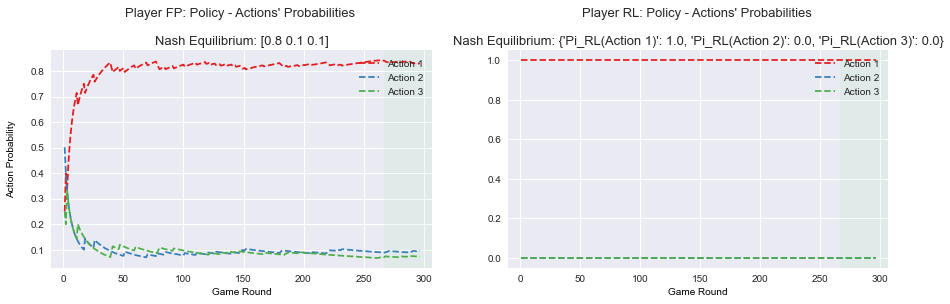

In [572]:
player_FP = FPZeroSumPlayer(payoff_matrix)
player_RL = RLZeroSumPlayer(alpha, gamma, explor, actions, initial_state)

game_log = play_fp_rl_game(player_FP, player_RL, payoff_matrix, actions_map, max_iterations, policy_delta_thres, stable_policy_delta_rounds_thres)

In [573]:
game_log

,round,action_FP,action_RL,reward_FP,reward_RL,beliefs_FP,policy_FP,V_RL,"Q_RL(Action 1,Action 1)","Q_RL(Action 1,Action 2)","Q_RL(Action 1,Action 3)","Q_RL(Action 2,Action 1)","Q_RL(Action 2,Action 2)","Q_RL(Action 2,Action 3)","Q_RL(Action 3,Action 1)","Q_RL(Action 3,Action 2)","Q_RL(Action 3,Action 3)",Pi_RL(Action 1),Pi_RL(Action 2),Pi_RL(Action 3)
0,NaN,NaN,NaN,NaN,NaN,"[0.333, 0.335, 0.333]","[0.333, 0.335, 0.333]",1,1,1,1,1,1,1,1,1,1,0.333333,0.333333,0.333333
1,1.0,Action 1,Action 2,0.0,0.0,"[0.25, 0.501, 0.25]","[0.25, 0.501, 0.25]",1.0,1,1,1,0.999153,1,1,1,1,1,1.000000,0.000000,0.000000
2,2.0,Action 1,Action 1,2.0,-2.0,"[0.399, 0.401, 0.2]","[0.399, 0.401, 0.2]",1.0,1.022093,1,1,0.999153,1,1,1,1,1,1.000000,0.000000,0.000000
3,3.0,Action 1,Action 3,1.0,-1.0,"[0.333, 0.334, 0.333]","[0.333, 0.334, 0.333]",1.0,1.022093,1,1,0.999153,1,1,1.008571,1,1,1.000000,0.000000,0.000000
4,4.0,Action 1,Action 1,2.0,-2.0,"[0.428, 0.286, 0.286]","[0.428, 0.286, 0.286]",1.0,1.043929,1,1,0.999153,1,1,1.008571,1,1,1.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,293.0,Action 1,Action 1,2.0,-2.0,"[0.831, 0.095, 0.074]","[0.831, 0.095, 0.074]",1.0,2.791789,1,1,0.97947,1,1,1.163848,1,1,1.000000,0.000000,0.000000
294,294.0,Action 1,Action 1,2.0,-2.0,"[0.832, 0.094, 0.074]","[0.832, 0.094, 0.074]",1.0,2.793048,1,1,0.97947,1,1,1.163848,1,1,1.000000,0.000000,0.000000
295,295.0,Action 1,Action 2,0.0,0.0,"[0.829, 0.097, 0.074]","[0.829, 0.097, 0.074]",1.0,2.793048,1,1,0.978797,1,1,1.163848,1,1,1.000000,0.000000,0.000000
296,296.0,Action 1,Action 1,2.0,-2.0,"[0.829, 0.097, 0.074]","[0.829, 0.097, 0.074]",1.0,2.794291,1,1,0.978797,1,1,1.163848,1,1,1.000000,0.000000,0.000000
